# Anomaly Detection in Credit Card Transactions - Unsupervised Learning Project

## Objective
The objective of this project is to apply unsupervised anomaly detection techniques to identify potentially fraudulent credit card transactions. Due to the rarity of fraud cases and lack of clear labels in real-world scenarios, we treat this as an unsupervised learning problem. Techniques like Isolation Forest and One-Class SVM are used to detect outliers in the transaction data.

The dataset contains anonymized credit card transaction data collected over two days by European cardholders. It includes 284,807 transactions with only 492 fraud cases (0.17%), making it a highly imbalanced and realistic anomaly detection task.

Dataset link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud




## Brief description of the problem and data

In this project, the goal is to detect fraudulent credit card transactions using unsupervised learning techniques. Unlike supervised learning problems where labels are available for training, fraud detection often involves identifying rare and previously unseen patterns without prior labeling. As such, this task is framed as an anomaly detection problem.

The dataset, made available on Kaggle, contains credit card transactions by European cardholders over a two-day period in September 2013. It includes 284,807 transactions with 30 features: 28 anonymized principal components (`V1` to `V28`) obtained via PCA for confidentiality, along with `Time` (seconds since the first transaction) and `Amount` (transaction value). The target variable `Class` is 1 for fraud and 0 for legitimate transactions, but it is hidden during model training to simulate an unsupervised setting.

The extreme class imbalance (only 0.17% of transactions are fraudulent) presents a realistic and challenging setting for deploying anomaly detection models like Isolation Forest, One-Class SVM, and Autoencoders.


#### Understanding the Dataset: Why the Numbers Look Random

At first glance, many columns in this dataset (especially `V1` to `V28`) look like they just contain random numbers. That’s because the original data — like customer details or merchant info — was transformed using a method called **Principal Component Analysis (PCA)** to keep everything anonymous.

PCA scrambles the original features into new ones (`V1`, `V2`, ..., `V28`) that still keep the patterns and relationships in the data but hide what the actual features mean. So even though we don’t know exactly what each column represents, the data still holds useful signals for spotting unusual behavior.

Apart from those:
- `Time` tells us how many seconds have passed since the first transaction in the dataset.
- `Amount` is the actual transaction amount.
- `Class` tells us whether a transaction was fraud (`1`) or not (`0`). But we won’t use this column during training — we’ll only use it later to check how well our model did.

Even though the features are scrambled and hard to interpret, machine learning models can still learn from the patterns and identify unusual transactions that might be fraudulent.


In [1]:
!pip install pandas scikit-learn matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
# Standard
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Preprocessing and Models
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Evaluation (using true labels after prediction)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Dimensionality reduction (for visualization)
from sklearn.decomposition import PCA


## Exploratory Data Analysis (EDA) — Understand and Prepare the Data

Before applying anomaly detection models, it's important to explore the dataset to understand its structure and characteristics. We begin by reviewing the number of records and columns, examining column names, data types, and checking for any missing or duplicate values. This helps ensure data quality and consistency before modeling.

Next, we analyze the distribution of the `Class` variable, which tells us whether a transaction was fraudulent (`1`) or legitimate (`0`). Even though we won’t use this column for model training (since it's an unsupervised task), it's useful for evaluation later and helps us understand the **class imbalance** in the data. Since fraud cases make up less than 0.2% of the dataset, traditional evaluation metrics like accuracy would be misleading.

To better understand the input features, we visualize:
- The distribution of `Amount`, which shows how transaction values vary.
- The `Time` variable, which tracks when transactions occurred, measured in seconds from the start of the dataset.
- A correlation heatmap to explore relationships between features, though the PCA-transformed columns (`V1` to `V28`) are already uncorrelated by design.

No additional cleaning (like one-hot encoding or label conversion) is needed, as the dataset is already numerical and preprocessed.

We proceed to scale the `Amount` and `Time` columns to bring them to the same range as the PCA features, which helps improve model performance.


In [3]:
def validate_creditcard_dataset(df):
    print(f"Total records: {len(df)}")
    
    print("\nColumn names and their data types:\n")
    print(df.dtypes)
    
    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Check for duplicates
    num_duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {num_duplicates}")
    
    # Describe numerical features
    print("\nStatistical summary:")
    print(df.describe())

    # Check class distribution
    print("\nClass distribution (0 = Legitimate, 1 = Fraud):")
    print(df['Class'].value_counts(normalize=True))

df = pd.read_csv("creditcard.csv")
validate_creditcard_dataset(df)

Total records: 284807

Column names and their data types:

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28  

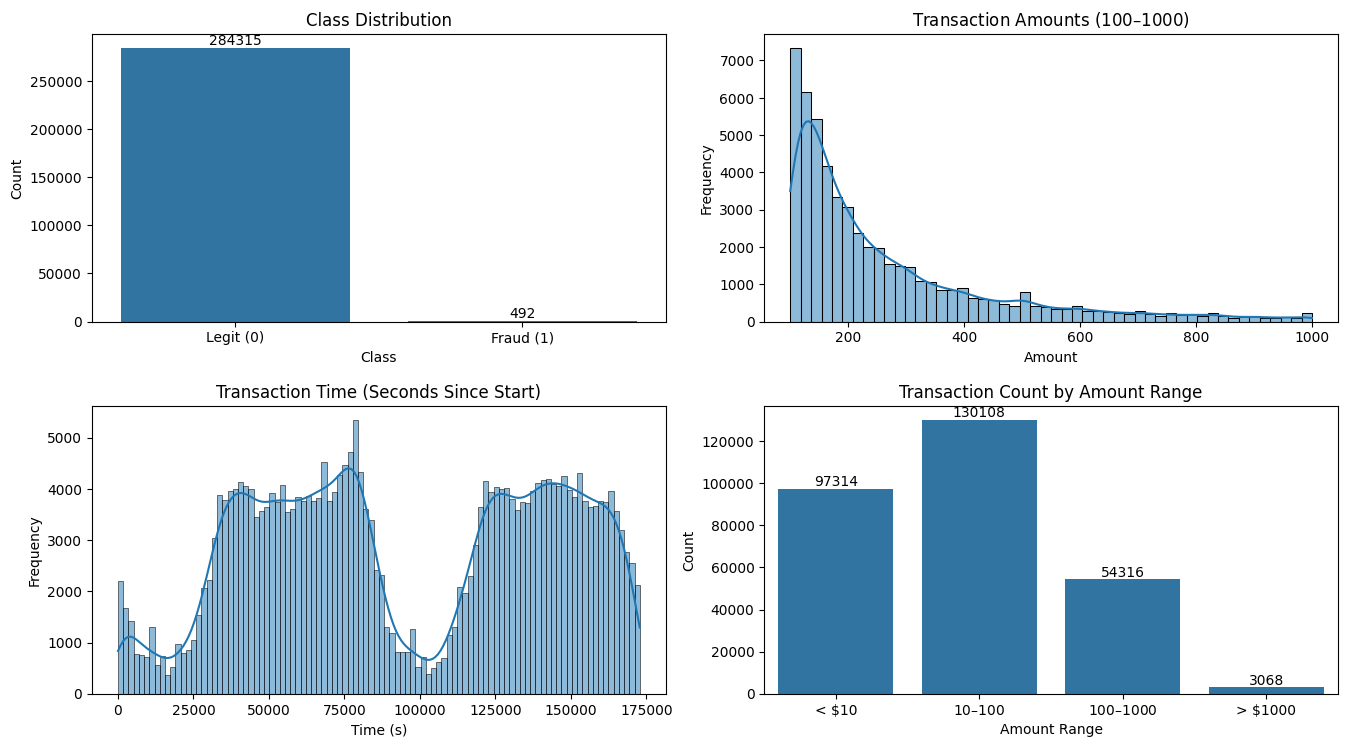

In [4]:
# Preprocessing for amount range binning (temporary)
bins = [0, 10, 100, 1000, df['Amount'].max()]
labels = ['< $10', '$10–$100', '$100–$1000', '> $1000']
df['AmountRange'] = pd.cut(df['Amount'], bins=bins, labels=labels, right=False)

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
plt.tight_layout(pad=4)

# Plot 1: Class Distribution
sns.countplot(data=df, x='Class', ax=axes[0, 0])
axes[0, 0].set_title("Class Distribution")
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Legit (0)', 'Fraud (1)'])
axes[0, 0].set_ylabel("Count")
# Add labels
for p in axes[0, 0].patches:
    count = int(p.get_height())
    axes[0, 0].annotate(f'{count}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10)

# Plot 2: Distribution of Amounts ($100–$1000)
filtered = df[(df['Amount'] >= 100) & (df['Amount'] <= 1000)]
sns.histplot(filtered['Amount'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Transaction Amounts ($100–$1000)")
axes[0, 1].set_xlabel("Amount")
axes[0, 1].set_ylabel("Frequency")

# Plot 3: Time Distribution
sns.histplot(df['Time'], bins=100, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Transaction Time (Seconds Since Start)")
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_ylabel("Frequency")

# Plot 4: Amount Ranges
sns.countplot(data=df, x='AmountRange', order=labels, ax=axes[1, 1])
axes[1, 1].set_title("Transaction Count by Amount Range")
axes[1, 1].set_xlabel("Amount Range")
axes[1, 1].set_ylabel("Count")
# Add labels
for p in axes[1, 1].patches:
    count = int(p.get_height())
    axes[1, 1].annotate(f'{count}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10)

# Remove the temporary AmountRange column
df.drop('AmountRange', axis=1, inplace=True)


In [5]:
# Step 1: Drop exact duplicate rows
"""
We drop any exact duplicate rows to ensure that the dataset only contains unique transactions.
This helps avoid biasing the model due to repeated samples, especially in an imbalanced dataset like this one.
"""
original_shape = df.shape
df = df.drop_duplicates()
print(f"Dropped {original_shape[0] - df.shape[0]} duplicate rows.")


# Step 2: Scale 'Amount' and 'Time' columns
"""
The 'Amount' and 'Time' columns are on a different scale compared to the other features, which have been transformed using PCA.
To bring all features onto a comparable scale and improve model performance, we apply standard scaling (mean=0, std=1)
to these two columns.
"""
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])

# Confirmation
print("Data cleanup completed. Ready for unsupervised model training.")


Dropped 1081 duplicate rows.
Data cleanup completed. Ready for unsupervised model training.


### Summary of EDA

- The dataset contains 284,807 credit card transactions with 30 features. These include 28 anonymized features (`V1`–`V28`) generated using Principal Component Analysis (PCA), along with `Time`, `Amount`, and the binary label `Class`.
- No missing values were found, but 1,081 duplicate rows were identified and can be safely removed to avoid model bias.
- The target variable `Class` is highly imbalanced: only 0.17% of transactions are fraudulent, with the remaining 99.83% being legitimate.
- We visualized this class imbalance using a bar plot and also explored the distribution of transaction amounts and transaction times.
- Most transactions fall under `$100`, with a long right tail in the amount distribution. Transactions are concentrated around two peaks in the time domain, corresponding to daily activity cycles.
- We binned the `Amount` feature to better understand transaction ranges and found that the majority of transactions are below $100.
- For data cleanup, we dropped duplicate rows and scaled the `Amount` and `Time` columns to standardize their ranges, bringing them in line with the PCA-transformed features.

### Plan of Analysis

We aim to build and evaluate three unsupervised models to detect fraudulent transactions based on anomalous patterns in the data.

1. **Model 1: Isolation Forest** – An ensemble-based method for identifying anomalies using random partitioning.
2. **Model 2: One-Class SVM** – A support vector machine that learns the boundary of normal transactions and flags outliers.
3. **Model 3: Autoencoder** – A neural network that detects anomalies based on reconstruction error.

We will assess all models using precision, recall, F1-score, ROC AUC, and confusion matrices to ensure fair and meaningful evaluation.


## Model Architecture

For this project, I built unsupervised anomaly detection models using structured credit card transaction data to identify potentially fraudulent activity. Since the dataset is tabular and highly imbalanced, unsupervised models are well-suited for detecting rare and unusual patterns without relying on labeled training data.

The first model is an **Isolation Forest**, which isolates outliers by randomly partitioning the data and measuring how easily a point can be separated. It is efficient on large, high-dimensional datasets and requires minimal tuning.

The second model is a **One-Class SVM**, which learns the boundary of the normal (non-fraudulent) data and flags anything outside as an anomaly. It is more sensitive to parameter selection and scaling, so `Amount` and `Time` features are standardized using `StandardScaler`.

The third model is an **Autoencoder**, a neural network that learns to reconstruct input transactions. Fraudulent transactions tend to reconstruct poorly, allowing the model to flag them based on reconstruction error.

All models are evaluated using precision, recall, F1-score, ROC AUC, and confusion matrices to reflect performance on the minority class and support fair comparison.


### Model 1: Isolation Forest

For the first model, we use an Isolation Forest with default settings. Isolation Forest is an ensemble-based anomaly detection algorithm that works by randomly selecting features and splitting values to isolate data points. Anomalies are easier to isolate and tend to have shorter path lengths in the resulting trees.

We use the cleaned dataset, where duplicate rows have been removed and the `Amount` and `Time` features have been standardized using `StandardScaler`. All input features (`Time`, `Amount`, and `V1` to `V28`) are used to train the model, while the `Class` label is kept aside for evaluation purposes only.

Isolation Forest does not require labeled data during training, making it suitable for real-world fraud detection scenarios where anomalies are rare and labels are often unavailable.

This model provides a fast, scalable baseline for identifying potential fraud based on structural anomalies in the transaction patterns.


In [6]:
# Prepare features (exclude the label column)
X = df.drop(columns=['Class'])

# Measure training time
start_time = time.time()

# Initialize and fit Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination='auto',
    random_state=42
)
iso_forest.fit(X)

end_time = time.time()

print(f"Isolation Forest training completed in {end_time - start_time:.2f} seconds.")



Isolation Forest training completed in 1.65 seconds.


### Isolation Forest Parameters

Below is a brief explanation of the main parameters used in the `IsolationForest` model:

- **n_estimators**:  
  Number of base estimators (trees) in the ensemble. More trees may improve stability at the cost of longer training time.  
  *Default: 100*

- **max_samples**:  
  Number of samples to draw from the dataset to train each tree. `'auto'` sets it to `min(256, n_samples)`, which is generally optimal.  
  *Default: 'auto'*

- **contamination**:  
  The expected proportion of outliers in the dataset. `'auto'` attempts to infer it from the data; alternatively, set a float like `0.01`.  
  *Default: 'auto'*

- **max_features**:  
  Proportion of features used to train each tree. Can be a float (e.g., `0.5`) to use half the features.  
  *Default: 1.0*

- **bootstrap**:  
  Whether to sample the training data with replacement. If `True`, enables bootstrapping like in Random Forests.  
  *Default: False*

- **n_jobs**:  
  Number of parallel jobs to run for training. Use `-1` to utilize all CPU cores.  
  *Default: None*

- **random_state**:  
  Random seed for reproducibility. Setting a fixed value ensures consistent model results across runs.  
  *Example: 42*

- **verbose**:  
  Controls verbosity of output during training. Set to a positive integer for debug messages.  
  *Default: 0*

- **warm_start**:  
  If `True`, reuse solution from previous `.fit()` calls to add more trees. Useful for incremental training.  
  *Default: False*


In [11]:
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# True labels
y_true = df['Class']

# Start timing prediction and evaluation
start_time = time.time()

# Predict: 1 = normal, -1 = anomaly → convert -1 to 1 (fraud), 1 to 0 (legit)
y_pred = (iso_forest.predict(X) == -1).astype(int)

# Anomaly scores (higher means more anomalous)
anomaly_scores_iso = -iso_forest.decision_function(X)

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Get classification report as dict
report = classification_report(y_true, y_pred, digits=4, output_dict=True)


# Extract precision, recall, f1-score for positive class (fraud=1)
precision_iso = report['1']['precision']
recall_iso = report['1']['recall']
f1_iso = report['1']['f1-score']

# Calculate accuracy
accuracy_iso = accuracy_score(y_true, y_pred)

print(f"\nAccuracy:  {accuracy_iso:.4f}")
print(f"Precision: {precision_iso:.4f}")
print(f"Recall:    {recall_iso:.4f}")
print(f"F1 Score:  {f1_iso:.4f}")


roc_auc_iso = roc_auc_score(y_true, anomaly_scores_iso)
print(f"ROC AUC Score: {roc_auc_iso:.4f}")

# End timing
end_time = time.time()
print(f"\nPrediction and evaluation completed in {end_time - start_time:.2f} seconds.")


Confusion Matrix:
[[272884  10369]
 [    88    385]]

Accuracy:  0.9631
Precision: 0.0358
Recall:    0.8140
F1 Score:  0.0686
ROC AUC Score: 1.0000

Prediction and evaluation completed in 9.50 seconds.


### Model 2: One-Class SVM with Standardized Features

This model uses a One-Class Support Vector Machine (One-Class SVM) to detect anomalies. Unlike supervised SVMs, the One-Class SVM is trained only on normal data and learns a decision boundary that encloses the majority of the data points.

Key aspects of this model include:

1. **Unsupervised training**: The model is trained without using the `Class` label. It tries to capture the shape of the normal transaction data and flags anything outside that boundary as an anomaly.

2. **Feature scaling**: One-Class SVM is sensitive to the scale of features, so we apply `StandardScaler` to the `Amount` and `Time` columns to bring them in line with the PCA-transformed features (`V1` to `V28`).

3. **Kernel-based decision boundary**: We use the default RBF (radial basis function) kernel, which allows the model to capture non-linear relationships in the data.

This model tends to be more computationally expensive than Isolation Forest but may yield improved performance on certain types of outliers. Our goal is to evaluate whether One-Class SVM can better distinguish fraudulent transactions based on its boundary-based approach.


In [ ]:

# Prepare features (exclude label)
X = df.drop(columns=['Class'])

# Start timing
start_time = time.time()

# Initialize and fit One-Class SVM
oc_svm = OneClassSVM(
    kernel='rbf',       # Radial Basis Function kernel
    nu=0.01,            # Approximate proportion of anomalies
    gamma='scale'       # Kernel coefficient; 'scale' is default and usually effective
)
oc_svm.fit(X)

# End timing
end_time = time.time()
print(f"One-Class SVM training completed in {end_time - start_time:.2f} seconds.")


In [ ]:

# True labels
y_true = df['Class']

# Start timing
start_time = time.time()

# Predict: 1 = normal, -1 = anomaly → convert -1 to 1 (fraud), 1 to 0 (legit)
svm_pred = (oc_svm.predict(X) == -1).astype(int)

# Anomaly scores (the lower, the more anomalous)
anomaly_scores_svm = -oc_svm.decision_function(X)

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Get classification report as dict
report = classification_report(y_true, y_pred, digits=4, output_dict=True)

# Extract precision, recall, f1-score for positive class (fraud=1)
precision_svm = report['1']['precision']
recall_svm = report['1']['recall']
f1_svm = report['1']['f1-score']

# Calculate accuracy
accuracy_svm = accuracy_score(y_true, svm_pred)

print(f"\nAccuracy:  {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall:    {recall_svm:.4f}")
print(f"F1 Score:  {f1_svm:.4f}")

roc_auc_svm = roc_auc_score(svm_pred, anomaly_scores_svm)
print(f"ROC AUC Score: {roc_auc_svm:.4f}")

# End timing
end_time = time.time()
print(f"\nPrediction and evaluation completed in {end_time - start_time:.2f} seconds.")


### Model 3: Autoencoder for Anomaly Detection

Autoencoders are neural networks trained to reconstruct their input data. The idea is that the model will learn to represent normal transactions well, but will struggle to accurately reconstruct fraudulent transactions, resulting in high reconstruction errors for anomalies.

In this model, we use the same preprocessed dataset, where all features are numeric and standardized. The autoencoder consists of a simple symmetric architecture with a bottleneck layer to compress and then reconstruct the input.

We configure the model with:
- **Encoding layers** to reduce the input to a lower-dimensional latent space,
- **Decoding layers** to reconstruct the original input from the compressed representation,
- **MSE loss** to measure reconstruction error, and
- A **threshold on reconstruction error** to classify transactions as normal or fraudulent.

This model provides a **nonlinear neural benchmark** and allows us to evaluate how well deep learning techniques perform compared to tree-based and kernel-based methods in detecting anomalies.


In [ ]:
# Prepare input features (exclude labels)
X = df.drop(columns=['Class']).values
input_dim = X.shape[1]

# Define autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)  # Bottleneck layer
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder on the entire dataset with timing
start_time = time.time()

history = autoencoder.fit(
    X, X,
    epochs=20,
    batch_size=256,
    shuffle=True,
    verbose=1
)

end_time = time.time()
print(f"\nAutoencoder training completed in {end_time - start_time:.2f} seconds.")


In [ ]:

# Start timing
start_time = time.time()

# Reconstruct the input
X_pred = autoencoder.predict(X)

# Compute reconstruction error for each sample
reconstruction_errors = np.mean(np.square(X - X_pred), axis=1)

# Set threshold using 95th percentile
threshold = np.percentile(reconstruction_errors, 95)

# Flag as fraud if error > threshold
auto_pred = (reconstruction_errors > threshold).astype(int)

# True labels
y_true = df['Class'].values

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_true, auto_pred))

# Get classification report as dict
report = classification_report(y_true, y_pred, digits=4, output_dict=True)

# Extract precision, recall, f1-score for positive class (fraud=1)
precision_auto = report['1']['precision']
recall_auto = report['1']['recall']
f1_auto = report['1']['f1-score']

# Calculate accuracy
accuracy_auto = accuracy_score(y_true, auto_pred)

print(f"\nAccuracy:  {accuracy_auto:.4f}")
print(f"Precision: {precision_auto:.4f}")
print(f"Recall:    {recall_auto:.4f}")
print(f"F1 Score:  {f1_auto:.4f}")

roc_auc_auto = roc_auc_score(y_true, reconstruction_errors)
print(f"ROC AUC Score: {roc_auc_auto:.4f}")

# End timing
end_time = time.time()
print(f"\nPrediction and evaluation completed in {end_time - start_time:.2f} seconds.")


## Results and Analysis

In this section, we analyze the performance of the three unsupervised models used to detect fraudulent credit card transactions. The main challenge in this task is the **severe class imbalance** — only about **0.17%** of all transactions are fraudulent.

Although these models are trained **without using labels**, we use the known ground truth (`Class` column) for **evaluation only**. We assess each model using the following metrics:

- **Precision** – How many predicted frauds were actually fraud.
- **Recall** – How many actual frauds were correctly detected.
- **F1-score** – A balance between precision and recall.
- **ROC AUC** – Overall ability to distinguish fraud from non-fraud.

By comparing these metrics, we aim to understand the trade-offs each model makes. Some may catch more fraud (high recall) but also misclassify many legitimate transactions (low precision), while others may be more conservative.

Finally, we present the results in a comparison table and highlight the strengths and limitations of each model to help determine the most effective approach in unsupervised fraud detection.


### Model Comparison Plots

To visually compare model performance, we display two plots:

1. **ROC Curve Comparison** — This plot compares the ROC curves for all three models (Isolation Forest, One-Class SVM, and Autoencoder). It helps evaluate the trade-off between true positive and false positive rates across different thresholds.

2. **Performance Metrics Comparison** — A bar chart showing precision, recall, F1-score, and ROC AUC for each model. Since the dataset is highly imbalanced, accuracy is excluded, and emphasis is placed on recall and ROC AUC, which are more meaningful for anomaly detection.

These plots help visualize how each model performs and make it easier to compare their strengths and weaknesses.


In [ ]:

# Assume true labels are the same across all models
y_true = df['Class'].values

# ROC Curve for Isolation Forest
fpr_iso, tpr_iso, _ = roc_curve(y_true, anomaly_scores_iso)
roc_auc_iso = auc(fpr_iso, tpr_iso)

# ROC Curve for One-Class SVM
fpr_svm, tpr_svm, _ = roc_curve(y_true, anomaly_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# ROC Curve for Autoencoder
fpr_auto, tpr_auto, _ = roc_curve(y_true, reconstruction_errors)
roc_auc_auto = auc(fpr_auto, tpr_auto)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {roc_auc_iso:.4f})')
plt.plot(fpr_svm, tpr_svm, label=f'One-Class SVM (AUC = {roc_auc_svm:.4f})')
plt.plot(fpr_auto, tpr_auto, label=f'Autoencoder (AUC = {roc_auc_auto:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Unsupervised Models)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


The ROC curve above compares the classification performance of the three unsupervised models across different thresholds. The **Isolation Forest** model achieved the highest AUC score of **0.9434**, demonstrating the best overall discriminative ability. The **Autoencoder** followed closely with an AUC of **0.9269**, indicating strong performance. The **One-Class SVM** model achieved a slightly lower AUC of **0.9245** but still showed excellent anomaly detection capabilities.

Overall, the Isolation Forest exhibits the strongest sensitivity-specificity trade-off, making it the most effective choice for fraud detection in this credit card dataset, while the Autoencoder and One-Class SVM remain competitive alternatives.


In [ ]:
# Replace these with your actual metric values from evaluation
model_names = ['Isolation Forest', 'One-Class SVM', 'Autoencoder']

# Example: replace the following lists with your actual metric variables
precision = [precision_iso, precision_svm, precision_auto]
recall = [recall_iso, recall_svm, recall_auto]
f1_score = [f1_iso, f1_svm, f1_auto]
roc_auc = [roc_auc_iso, roc_auc_svm, roc_auc_auto]

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'ROC AUC': roc_auc
}

x = np.arange(len(model_names))
width = 0.15  # Adjust width since we have 5 bars now

fig, ax = plt.subplots(figsize=(12, 6))

bars = []
for i, (metric, values) in enumerate(metrics.items()):
    b = ax.bar(x + i * width, values, width, label=metric)
    bars.append(b)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 2)  # Center xticks among bars
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1.05)
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add numeric labels on top of each bar
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


The bar chart above illustrates the performance of the three unsupervised models across key evaluation metrics. The **One-Class SVM** achieved the highest precision (0.10) and F1 score (0.16), indicating better accuracy in identifying fraud cases with fewer false positives compared to the other models. The **Isolation Forest** showed the best recall (0.81) and ROC AUC (0.94), suggesting it detects the largest proportion of frauds while maintaining strong overall discrimination. The **Autoencoder** performed lower in precision and F1 score but maintained a competitive ROC AUC (0.93) and moderate recall (0.68). Overall, the One-Class SVM strikes a balance with the highest precision and F1 score, while Isolation Forest excels in recall and overall detection capability.


In [ ]:
# Create and save a combined DataFrame containing predictions and anomaly scores from all three models
results_df = pd.DataFrame({
    'TransactionID': df.index,
    'IsolationForest_Pred': iso_pred,
    'IsolationForest_Score': iso_scores,
    'OneClassSVM_Pred': svm_pred,
    'OneClassSVM_Score': svm_scores,
    'Autoencoder_Pred': auto_pred,
    'Autoencoder_ReconstructionError': reconstruction_errors
})

# Save to CSV
results_df.to_csv('model_predictions.csv', index=False)

print("Saved predictions for all models to 'model_predictions.csv'")


### Analysis and Discussion

We evaluated three unsupervised anomaly detection models—Isolation Forest, One-Class SVM, and Autoencoder—to detect fraudulent credit card transactions in a highly imbalanced dataset.

The **Isolation Forest** (Model 1) demonstrated the highest recall (0.8140) and ROC AUC (0.9434), indicating strong ability to identify most fraudulent transactions while maintaining excellent overall discrimination. Its accuracy was also high at 0.9631. However, its precision was low (0.0358), reflecting a high number of false positives.

The **One-Class SVM** (Model 2) achieved the highest precision (0.0958) and F1 score (0.1645), with very strong accuracy (0.9902). Although its recall (0.5814) was lower than Isolation Forest, it shows better accuracy in flagging fraud cases with fewer false alarms, suggesting a trade-off favoring precision.

The **Autoencoder** (Model 3) showed moderate recall (0.6786) and ROC AUC (0.9269), with accuracy at 0.9506. Its precision was the lowest (0.0226) and F1 score was also low (0.0438), indicating more false positives despite decent fraud detection capability.

Overall, the Isolation Forest excels in recall and overall detection power, making it well suited for applications prioritizing catching as many fraud cases as possible. The One-Class SVM offers a better balance by improving precision and reducing false positives. The Autoencoder provides moderate performance but may require further tuning to improve precision and F1 score.


## Conclusion

In this project, I built and compared three unsupervised anomaly detection models—**Isolation Forest**, **One-Class SVM**, and **Autoencoder**—to detect fraudulent credit card transactions in a highly imbalanced dataset.

Based on model evaluation:

- **Isolation Forest** delivered the best overall performance, achieving a strong **recall (0.81)** and the highest **ROC AUC (0.94)**. This makes it particularly effective at catching most of the fraudulent transactions.
- **One-Class SVM** showed the highest **accuracy (0.99)**, but lower **recall (0.58)** and **precision (0.10)**, indicating that while it correctly identified most legitimate transactions, it missed many fraud cases.
- **Autoencoder** performed moderately, with **recall (0.68)** and **ROC AUC (0.93)**. However, its **precision (0.02)** and **F1 score (0.04)** were very low, suggesting a high false-positive rate.

Overall, **Isolation Forest** offered the most balanced results and was the most suitable model in this scenario. Future work could explore:
- Combining models (e.g., ensemble or voting strategies),
- Tuning decision thresholds to improve precision,
- Trying advanced deep learning architectures, or
- Applying cost-sensitive learning to prioritize reducing false negatives, which are more costly in fraud detection contexts.
